### Just run cells below blue headings to check the output. As the dataset is too large we have stored the output feature training in pickle files. So you can just run cells below headings to save time.

## Importing the required libraries

In [49]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy.interpolate import griddata
sns.set()

In [2]:
image_folders = ['thispersondoesntexists_10K', '100KFake_10K','Flickr-Faces-HQ_10K', 'celebA-HQ_10K']
image_data = []
label_data = [1]*2500+[0]*2500
for folder in image_folders:
    c = 0
    for filename in os.listdir('faces/Frequency/Faces-HQ/'+folder):
        folder_path = 'faces/Frequency/Faces-HQ/'+folder+'/' 
        img = cv2.imread(folder_path+filename,0)
        image_data.append(img)
        c+=1
        if c==1250:
            break

In [3]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [4]:
transformed_data = []

for img in image_data:
    tranf = np.fft.fft2(img)
    transhift = np.fft.fftshift(tranf)
    transhift += 1e-8
    magnitude_spectrum = 20*np.log(np.abs(transhift))
    rad_mean = azimuthalAverage(magnitude_spectrum)
    nan_mean = np.nanmean(rad_mean)
    inds = np.where(np.isnan(rad_mean))
    rad_mean[inds] = nan_mean
    transformed_data.append(rad_mean)

In [5]:
output = open('dataset_freq_5000.pkl', 'wb')
pickle.dump({'X':transformed_data,'Y':label_data}, output)
output.close()

## Below is pickle file of feature training for paper implementation using high quality dataset

In [50]:
pkl_file=open('dataset_freq_5000.pkl', 'rb')
data=pickle.load(pkl_file)
transformed_data=data["X"]
label_data=data["Y"]

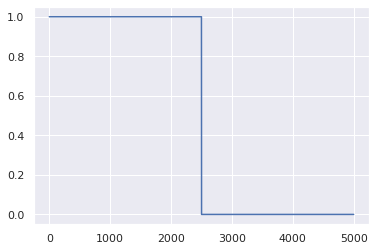

In [51]:
plt.plot(label_data)

## Splitting training and test sets

In [52]:
X_train, X_test, Y_train, Y_test= train_test_split(transformed_data,label_data,test_size=0.2,shuffle=True)

## svm and lr implementation

In [53]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train,Y_train)

LogR = LogisticRegression(solver='liblinear', max_iter=1000)
LogR.fit(X_train,Y_train)

SVM_score = svclassifier.score(X_test,Y_test)
LogR_score = LogR.score(X_test,Y_test)

print(SVM_score)
print(LogR_score)

1.0
1.0


## checking the accuracy for 10 iterations of svm and lr

In [54]:
SVM=0
LogRs=0
for i in range(10):
    pkl_file = open('dataset_freq_5000.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    X = data["X"]
    y = data["Y"]
    X_train, X_test, Y_train, Y_test= train_test_split(X,y,test_size=0.2,shuffle=True)
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train,Y_train)

    LogR = LogisticRegression(solver='liblinear', max_iter=2000)
    LogR.fit(X_train,Y_train)

    SVM_score = svclassifier.score(X_test,Y_test)
    LogR_score = LogR.score(X_test,Y_test)
    SVM+=SVM_score/10.0
    LogRs+=LogR_score/10.0
print(SVM)
print(LogRs)

0.9996999999999999
0.9996999999999999


## k-means clustering 

In [55]:
kmeans = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=42)
kmeans.fit(X_train)
y_train_labels = kmeans.labels_
y_test_labels = kmeans.predict(X_test)

## confusion matrix

0.791

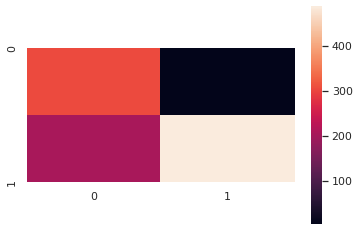

In [56]:
mat = confusion_matrix(y_test_labels, Y_test)
sns.heatmap(mat,square=True,cbar=True)
accuracy_score(y_test_labels,Y_test)

In [13]:
celeb_imagefolders=["celeb_A_Fake","img_align_celeba"]
celeb_image_data=[]
celeb_label_data=[1]*1000+[0]*1000
limit=1000
for folder in celeb_imagefolders:
    c=0
    for filename in os.listdir('Celeb_A/'+folder):
        folder_path = 'Celeb_A/'+folder+'/' 
        img = cv2.imread(folder_path+filename,0)
        if np.array(img).any() != None:
            celeb_image_data.append(img)
            c+=1
        if c==limit:
#             limit*=2
            break

In [14]:
celeb_transformed_data=[]
N=80
for i,img in enumerate(celeb_image_data):
    tranf = np.fft.fft2(img)
    transhift = np.fft.fftshift(tranf)
    transhift += 1e-8
    magnitude_spectrum = 20*np.log(np.abs(transhift))
    rad_mean = azimuthalAverage(magnitude_spectrum)
    points = np.linspace(0,N,num=rad_mean.size)
    xi = np.linspace(0,N,num=N)
    interpolated = griddata(points,rad_mean,xi,method='cubic')
    interpolated /= interpolated[0]
    rad_mean = interpolated
    celeb_transformed_data.append(rad_mean)


In [15]:
output = open('celeb_dataset_freq_2000.pkl', 'wb')
pickle.dump({'X':celeb_transformed_data,'Y':celeb_label_data}, output)
output.close()

## implementation of research paper with celeb dataset

In [57]:
celeb_pkl_file=open('celeb_dataset_freq_2000.pkl', 'rb')
celeb_data=pickle.load(celeb_pkl_file)
celeb_transformed_data=celeb_data["X"]
celeb_label_data=celeb_data["Y"]

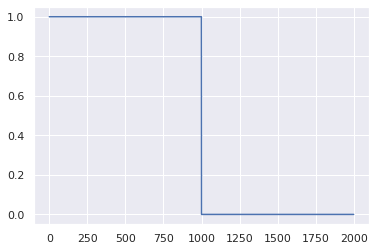

In [58]:
plt.plot(celeb_label_data)

## splitting the dataset into training and testing data

In [59]:
celeb_X_train, celeb_X_test, celeb_Y_train, celeb_Y_test= train_test_split(celeb_transformed_data,celeb_label_data,test_size=0.2,shuffle=True)

## svm and lr implementation

In [60]:
celeb_svclassifier = SVC(kernel='linear')
celeb_svclassifier.fit(celeb_X_train,celeb_Y_train)

celeb_svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
celeb_svclassifier_r.fit(celeb_X_train, celeb_Y_train)

celeb_svclassifier_p = SVC(kernel='poly')
celeb_svclassifier_p.fit(celeb_X_train, celeb_Y_train)

celeb_LogR = LogisticRegression(solver='liblinear', max_iter=1000)
celeb_LogR.fit(celeb_X_train,celeb_Y_train)

celeb_SVM_score = celeb_svclassifier.score(celeb_X_test,celeb_Y_test)
celeb_SVM_r_score = celeb_svclassifier_r.score(celeb_X_test,celeb_Y_test)
celeb_SVM_p_score = celeb_svclassifier_p.score(celeb_X_test,celeb_Y_test)
celeb_LogR_score = celeb_LogR.score(celeb_X_test,celeb_Y_test)

print(celeb_SVM_score)
print(celeb_SVM_r_score)
print(celeb_SVM_p_score)
print(celeb_LogR_score)

0.9375
0.9975
1.0
0.92


## k-means clustering

In [61]:
celeb_kmeans = KMeans(n_clusters=2, init='random',n_init=10, max_iter=500,tol=1e-04, random_state=42)
celeb_kmeans.fit(celeb_X_train)
celeb_y_train_labels = celeb_kmeans.labels_
celeb_y_test_labels = celeb_kmeans.predict(celeb_X_test)

## confusion matrix

0.3875

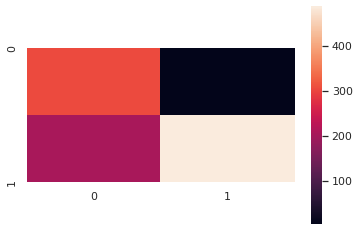

In [62]:
celeb_mat = confusion_matrix(celeb_y_test_labels,  celeb_Y_test)
sns.heatmap(mat,square=True,cbar=True)
accuracy_score(celeb_y_test_labels,celeb_Y_test)

In [23]:
make_histogram = lambda: np.zeros(256, dtype='int')
DIRECTIONS = ('h', 'dr', 'v', 'dl')

def neighbours(x, y):
    return [
        (x-1, y-1), (x-1, y), (x-1, y+1), (x, y+1),
        (x+1, y+1), (x+1, y), (x+1, y-1), (x, y-1)
    ]

def g(a, b):
    # hey, this shit makes g() 10s/50imgs faster
    if a == 0 or b == 0: return -1

    p = np.sign(a*b)
    if p == -1: return 1
    if p == 1: return  0
    if p == 0: return -1

def extract_feature(img):
    cimg = img[1:-1, 1:-1]
    # first-order derivate
    i = {'h': cimg - img[1:-1, 2:],
         'v': cimg - img[:-2, 1:-1],
         'dr': cimg - img[:-2, 2:],
         'dl': cimg - img[:-2, :-2],
    }

    width, height = cimg.shape
    indices = ((x, y) for x in range(1, width-1) for y in range(1, height-1))

    histograms = dict(
        ltpp = {'h':  make_histogram(),
                'v':  make_histogram(),
                'dr': make_histogram(),
                'dl': make_histogram(),
        },
        ltpn = {'h':  make_histogram(),
                'v':  make_histogram(),
                'dr': make_histogram(),
                'dl': make_histogram(),
        },
    )

    for (px, py) in indices:
        for direction in DIRECTIONS:
            # centred, first order derivate of image
            p = i[direction][px, py]

            ltpp = ['0', ] * 8
            ltpn = ['0', ] * 8
            for dc, (x, y) in enumerate(neighbours(px, py)):
                ltp = g(i[direction][x, y], p)
                if ltp == 1: ltpp[dc] = '1'
                if ltp == -1: ltpn[dc] = '1'

            ltpp = int(''.join(ltpp), 2)
            ltpn = int(''.join(ltpn), 2)
            histograms['ltpp'][direction][ltpp] += 1
            histograms['ltpn'][direction][ltpn] += 1

    return np.concatenate([histograms[sign][direction]
                           for direction in DIRECTIONS
                           for sign in ('ltpp', 'ltpn')])

In [26]:
improve_celeb_transformed_data=[]
N=80

for i,img in enumerate(celeb_image_data):
    img = cv2.resize(img,(128,128))
    rad_mean=extract_feature(img)
    improve_celeb_transformed_data.append(rad_mean)


2000
0


/home/yggdrasil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [29]:
output = open('improve_celeb_dataset_freq_2000.pkl', 'wb')
pickle.dump({'X':improve_celeb_transformed_data,'Y':celeb_label_data}, output)
output.close()

## celeb dataset implementation for improved version

In [63]:
improve_celeb_pkl_file=open('improve_celeb_dataset_freq_2000.pkl', 'rb')
improve_celeb_data=pickle.load(improve_celeb_pkl_file)
improve_celeb_transformed_data=improve_celeb_data["X"]
improve_celeb_label_data=improve_celeb_data["Y"]

## splitting the data

In [64]:
improve_celeb_X_train, improve_celeb_X_test, improve_celeb_Y_train, improve_celeb_Y_test= train_test_split(improve_celeb_transformed_data,celeb_label_data,test_size=0.2,shuffle=True)

## svm and lr 

In [65]:
improve_celeb_svclassifier = SVC(kernel='linear')
improve_celeb_svclassifier.fit(improve_celeb_X_train,improve_celeb_Y_train)

improve_celeb_LogR = LogisticRegression(solver='liblinear', max_iter=1000)
improve_celeb_LogR.fit(improve_celeb_X_train,improve_celeb_Y_train)

improve_celeb_SVM_score = improve_celeb_svclassifier.score(improve_celeb_X_test,improve_celeb_Y_test)
improve_celeb_LogR_score = improve_celeb_LogR.score(improve_celeb_X_test,improve_celeb_Y_test)

print(improve_celeb_SVM_score)
print(improve_celeb_LogR_score)

0.98
0.9825


In [32]:
prepro_imagefolders=["fake","real"]
prepro_image_data=[]
prepro_label_data=[]
for folder in prepro_imagefolders:
    for subdir, dirs, files in os.walk('deepFakeDetection/prepro_deepFake/'+folder):
        for sdir in dirs:
            if sdir!='.ipynb_checkpoints':
                for files in os.listdir('deepFakeDetection/prepro_deepFake/'+folder+'/'+sdir):
                    folder_path='deepFakeDetection/prepro_deepFake/'+folder+'/'+sdir+'/'
                    img = cv2.imread(folder_path+files,0)
                    if np.array(img).any() != None:
                        prepro_image_data.append(img)
                        if folder == 'fake':
                            prepro_label_data.append(1)
                        else:
                            prepro_label_data.append(0)

In [33]:
prepro_transformed_data=[]
N=500
for img in prepro_image_data:
    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]
    tranf = np.fft.fft2(img)
    transhift = np.fft.fftshift(tranf)
    transhift += 1e-8
    magnitude_spectrum = 20*np.log(np.abs(transhift))
    rad_mean = azimuthalAverage(magnitude_spectrum)
    points = np.linspace(0,N,num=rad_mean.size)
    xi = np.linspace(0,N,num=N)
    interpolated = griddata(points,rad_mean,xi,method='cubic')
    interpolated /= interpolated[0]
    rad_mean = interpolated
    prepro_transformed_data.append(rad_mean)

In [34]:
output = open('prepro_dataset.pkl', 'wb')
pickle.dump({'X':prepro_transformed_data,'Y':prepro_label_data}, output)
output.close()

## research paper implementation for video images(low quality)

In [66]:
prepro_pkl_file=open('prepro_dataset.pkl', 'rb')
prepro_data=pickle.load(prepro_pkl_file)
prepro_transformed_data=prepro_data["X"]
prepro_label_data=prepro_data["Y"]

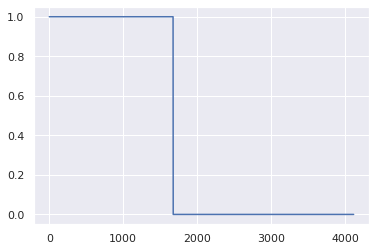

In [43]:
plt.plot(prepro_label_data)

## splitting the data

In [67]:
prepro_X_train, prepro_X_test, prepro_Y_train, prepro_Y_test= train_test_split(prepro_transformed_data,prepro_label_data,test_size=0.2,shuffle=True)

## svm and lr for that data

In [68]:
prepro_svclassifier = SVC(kernel='linear')
prepro_svclassifier.fit(prepro_X_train,prepro_Y_train)

prepro_LogR = LogisticRegression(solver='liblinear', max_iter=500)
prepro_LogR.fit(prepro_X_train,prepro_Y_train)

prepro_SVM_score = prepro_svclassifier.score(prepro_X_test,prepro_Y_test)
prepro_LogR_score = prepro_LogR.score(prepro_X_test,prepro_Y_test)

print(prepro_SVM_score)
print(prepro_LogR_score)

0.8286755771567437
0.8250303766707169


In [42]:
improve_prepro_transformed_data=[]
N=500

for i,img in enumerate(prepro_image_data):
    img=cv2.resize(img,(256,256))
    h = int(img.shape[0]/4)
    w = int(img.shape[1]/4)
    img = img[h:-h,w:-w]
    rad_mean=extract_feature(img)
    improve_prepro_transformed_data.append(rad_mean)

4115
0


/home/yggdrasil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100


In [48]:
output = open('improve_prepro_dataset.pkl', 'wb')
pickle.dump({'X':improve_prepro_transformed_data,'Y':prepro_label_data}, output)
output.close()

## improved version implementation with low quality images

In [69]:
improve_prepro_pkl_file=open('improve_prepro_dataset.pkl', 'rb')
improve_prepro_data=pickle.load(improve_prepro_pkl_file)
improve_prepro_transformed_data=improve_prepro_data["X"]
improve_prepro_label_data=improve_prepro_data["Y"]

## splitting the data

In [70]:
improve_prepro_X_train, improve_prepro_X_test, improve_prepro_Y_train, improve_prepro_Y_test= train_test_split(improve_prepro_transformed_data,improve_prepro_label_data,test_size=0.2,shuffle=True)

## svm and lr (this will take around 2 min)

In [71]:
improve_prepro_svclassifier = SVC(kernel='linear')
improve_prepro_svclassifier.fit(improve_prepro_X_train,improve_prepro_Y_train)

improve_prepro_LogR = LogisticRegression(solver='liblinear', max_iter=500)
improve_prepro_LogR.fit(improve_prepro_X_train,improve_prepro_Y_train)

improve_prepro_SVM_score = improve_prepro_svclassifier.score(improve_prepro_X_test,improve_prepro_Y_test)
improve_prepro_LogR_score = improve_prepro_LogR.score(improve_prepro_X_test,improve_prepro_Y_test)

print(improve_prepro_SVM_score)
print(improve_prepro_LogR_score)

0.8784933171324423
0.9040097205346294
